# Recommender System : Matrix Factorization

## Data Preparation

In [1]:
# pip install tensorflow-gpu
# pip install tensorflow
# pip install keras

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Dense , merge
from keras.layers.merge import dot
from keras import models
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
import pickle
sns.set_style('dark')
%matplotlib inline

### Import Datasets

In this assignment, I am using two datasets that contains different data about the movies. The datasets are : 
 - ratings.csv  : Contains data about the ratings and the users who rated the movies.
 - movies.csv   : Contains data about the movie titles and the genres.

In [2]:
#Import data about the movie ratings, no movie titles yet
ratings_data = pd.read_csv('ratings.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
#Import data about the movie titles and genres
titles_genres_data = pd.read_csv('movies.csv')
titles_genres_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Integrate the data
Combine all the three dataframes into one main dataframe and remove unnecessary columns.

In [4]:
full_data = pd.merge(ratings_data, titles_genres_data, how='outer', on=['movieId'])

full_data = full_data.dropna(axis=0, how='any')
full_data

,userId,movieId,rating,timestamp,title,genres
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610.0,160341,2.5,1.479546e+09,Bloodmoon (1997),Action|Thriller
100832,610.0,160527,4.5,1.479545e+09,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610.0,160836,3.0,1.493845e+09,Hazard (2005),Action|Drama|Thriller
100834,610.0,163937,3.5,1.493849e+09,Blair Witch (2016),Horror|Thriller


In [5]:
full_data.dtypes

userId       float64
movieId        int64
rating       float64
timestamp    float64
title         object
genres        object
dtype: object

## Data Exploration
- To understand the data I have prepared

In [6]:
full_data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


- Observe how many titles, users and tags there are

In [7]:
print("Number of unique movie titles : ", full_data['title'].nunique())
print("Number of unique users: ", full_data['userId'].nunique())
print("Number of unique genres: ", full_data['genres'].nunique())

Number of unique movie titles :  9719
Number of unique users:  610
Number of unique genres:  951


1554 unique titles and 610 unique users mean that we can have a total of 1554 * 610 = 947940 ratings.

 - UserID and the number of movies they have rated

In [8]:
full_data['userId'].value_counts(ascending=True)

194.0      20
207.0      20
147.0      20
320.0      20
569.0      20
         ... 
274.0    1346
448.0    1864
474.0    2108
599.0    2478
414.0    2698
Name: userId, Length: 610, dtype: int64

 - Movie titles and the number of ratings they have received

In [9]:
full_data['rating'].min()

0.5

 In the heatmap below, we can see that there are no missing data in the dataset. No handling of missing data is required here.


<AxesSubplot:>

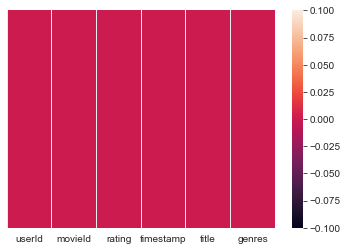

In [10]:
sns.heatmap(data=full_data.isnull(), yticklabels=False)

### Create a matrix with Movie titles as columns and userID as rows with ratings as the value

 - NaN means the user has not rated the movie yet

In [11]:
# creating utility matrix.
rows=list(full_data['userId'].unique())
columns=list(full_data['movieId'].unique())
rows=sorted(rows)
columns=sorted(columns)
 
ratings_matrix = pd.pivot_table(data=full_data,values='rating',index='userId',columns='movieId')
ratings_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608.0,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
ratings_matrix.isnull().sum().sum()

5830804

There are 5830804 ratings that are missing and we need to estimate and fill them up with the estimated ratings. If we fill up all the ratings, we would have 610 * 9724 = 5931640 number of ratings. However we only have 5931640 - 5830804 = 100836 number of ratings currently.

### Handling the missing user ratings

 - Now we fill NaN with 0, note that 0 does not mean the user rated the movie with 0 rating, the lowest actual rating is 0.5.

In [13]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608.0,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data into traning sets and testing sets.

In [14]:
users = full_data.userId.unique()
movies = full_data.movieId.unique()

# change userID to index
userid2Idx = {o:i for i,o in enumerate(users)}
movieid2Idx = {o:i for i,o in enumerate(movies)}
full_data = full_data.assign(user_Index = full_data.userId)
full_data = full_data.assign(movie_Index = full_data.movieId)
full_data['user_Index'] = full_data['user_Index'].apply(lambda x: userid2Idx[x])
full_data['movie_Index'] = full_data['movie_Index'].apply(lambda x: movieid2Idx[x])
full_data

,userId,movieId,rating,timestamp,title,genres,user_Index,movie_Index
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,0
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,0
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,0
...,...,...,...,...,...,...,...,...
100831,610.0,160341,2.5,1.479546e+09,Bloodmoon (1997),Action|Thriller,214,9719
100832,610.0,160527,4.5,1.479545e+09,Sympathy for the Underdog (1971),Action|Crime|Drama,214,9720
100833,610.0,160836,3.0,1.493845e+09,Hazard (2005),Action|Drama|Thriller,214,9721
100834,610.0,163937,3.5,1.493849e+09,Blair Witch (2016),Horror|Thriller,214,9722


In [15]:
train, test = train_test_split(full_data, test_size = 0.2, random_state = 42)
print(train.shape , test.shape)

(80668, 8) (20168, 8)


In [16]:
num_latent_features = 100 # Number of features for the reduced matrixes #TnE
num_users = full_data.userId.nunique()
num_movies = full_data.movieId.nunique()
num_users, num_movies

(610, 9724)

## Model Building 

 - Create the user & movie embeddings, and flatten it into one dimentional

In [18]:
user_input = Input(shape=(1,),name='User_Input',dtype='int64')
U = Embedding(num_users,num_latent_features,name='User_Embedding')(user_input)
U =Flatten(name='Flatten_Users')(U)

In [19]:
movie_input = Input(shape=(1,),name='Movie_Input',dtype='int64')
M = Embedding(num_movies,num_latent_features,name='Movie_Embedding')(movie_input)
M =Flatten(name='Flatten_Movies')(M)

 - Add dropout layer to reduce overfitting

In [20]:
user_dropout = Dropout(0.50)(U) #TnE
movie_dropout = Dropout(0.50)(M) #TnE

In [21]:
dot_product = dot([user_dropout,movie_dropout],name='Simalarity-Dot-Product',axes=1)
nn_input = Dense(50,activation='relu')(dot_product) #TnE
nn_input = Dropout(0.5)(nn_input) #TnE
nn_input = Dense(1,activation='relu')(nn_input) # 1 output
nn = models.Model([user_input, movie_input],nn_input)
nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User_Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 100)       61000       User_Input[0][0]                 
__________________________________________________________________________________________________
Movie_Embedding (Embedding)     (None, 1, 100)       972400      Movie_Input[0][0]                
______________________________________________________________________________________________

In [22]:
nn.compile(optimizer=Adam(learning_rate=0.001),loss='mse')  #TnE

 - Train the model by fitting in train and test dataset

In [23]:
%%time
History = nn.fit([train.user_Index,train.movie_Index],train.rating, batch_size=64,
                              epochs = 60, validation_data = ([test.user_Index,test.movie_Index],test.rating),
                              verbose = 1) #TnE : batch_size

Epoch 1/60
1261/1261 [==============================] - 16s 12ms/step - loss: 2.3303 - val_loss: 1.0824
Epoch 2/60
1261/1261 [==============================] - 15s 12ms/step - loss: 1.3760 - val_loss: 1.0837
Epoch 3/60
1261/1261 [==============================] - 15s 12ms/step - loss: 1.2312 - val_loss: 0.9745
Epoch 4/60
1261/1261 [==============================] - 17s 14ms/step - loss: 0.9911 - val_loss: 0.9064
Epoch 5/60
1261/1261 [==============================] - 17s 14ms/step - loss: 0.8227 - val_loss: 0.8652
Epoch 6/60
1261/1261 [==============================] - 15s 12ms/step - loss: 0.7105 - val_loss: 0.8457
Epoch 7/60
1261/1261 [==============================] - 18s 14ms/step - loss: 0.6318 - val_loss: 0.8361
Epoch 8/60
1261/1261 [==============================] - 16s 12ms/step - loss: 0.5837 - val_loss: 0.8321
Epoch 9/60
1261/1261 [==============================] - 15s 12ms/step - loss: 0.5578 - val_loss: 0.8225
Epoch 10/60
1261/1261 [==============================] - 15s 12m

 - Visualizing the training progress of the model

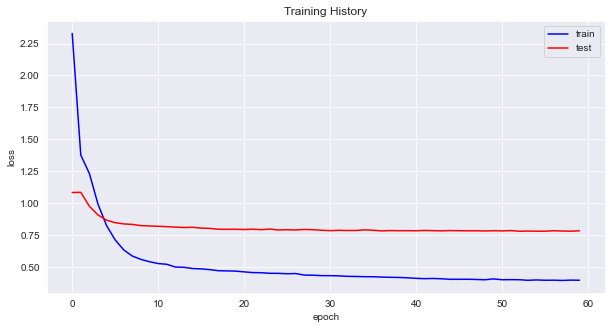

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.plot(History.history['loss'] , 'b')
plt.plot(History.history['val_loss'] , 'r')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

 - Testing the model's performance

In [25]:
predict_train = nn.predict([train.user_Index,train.movie_Index])
predict_test = nn.predict([test.user_Index,test.movie_Index])


In [26]:
MSE_train = mean_squared_error(train.rating, predict_train)
print("MSE of training data :", MSE_train)
RMSE_train = math.sqrt(MSE_train)
print("RMSE of training data :", RMSE_train)

print()
MSE_test = mean_squared_error(test.rating, predict_test)
print("MSE of testing data :", MSE_test)
RMSE_test = math.sqrt(MSE_test)
print("RMSE of testing data :", RMSE_test)

MSE of training data : 0.19576292074676602
RMSE of training data : 0.44245103768300287

MSE of testing data : 0.7819866353719908
RMSE of testing data : 0.8843000821960783


 - Compare the predicted ratings with the train and test data ratings

In [27]:
predict_train[:10]

array([[4.5701394],
       [4.5894337],
       [3.7797596],
       [3.9271398],
       [3.269551 ],
       [1.7023265],
       [3.8191721],
       [4.2420692],
       [4.4937906],
       [3.963303 ]], dtype=float32)

In [28]:
train[:10]

,userId,movieId,rating,timestamp,title,genres,user_Index,movie_Index
80568,275.0,2917,5.0,1.049077e+09,Body Heat (1981),Crime|Thriller,99,3031
50582,295.0,1221,4.5,1.320065e+09,"Godfather: Part II, The (1974)",Crime|Drama,364,1136
8344,140.0,1240,3.0,9.428412e+08,"Terminator, The (1984)",Action|Sci-Fi|Thriller,47,81
99603,606.0,5613,4.0,1.171501e+09,8 Women (2002),Comedy|Crime|Musical|Mystery,210,8597
71701,182.0,2231,3.0,1.055158e+09,Rounders (1998),Drama,65,2183
95405,603.0,4030,1.0,9.807322e+08,Dracula 2000 (2000),Horror,207,6204
13938,274.0,2858,5.0,1.171409e+09,American Beauty (1999),Drama|Romance,98,184
52544,200.0,2918,5.0,1.229887e+09,Ferris Bueller's Day Off (1986),Comedy,70,1179
64437,45.0,1035,5.0,1.034344e+09,"Sound of Music, The (1965)",Musical|Romance,15,1774
22977,555.0,2683,5.0,9.787470e+08,Austin Powers: The Spy Who Shagged Me (1999),Action|Adventure|Comedy,188,399


In [29]:
predict_test[:10]

array([[3.73232  ],
       [3.5928867],
       [3.4531012],
       [4.105756 ],
       [3.3899312],
       [4.0269465],
       [3.99605  ],
       [3.6440558],
       [3.258096 ],
       [3.410839 ]], dtype=float32)

In [30]:
test[:10]

,userId,movieId,rating,timestamp,title,genres,user_Index,movie_Index
67037,551.0,34162,4.0,1.504926e+09,Wedding Crashers (2005),Comedy|Romance,341,1891
42175,232.0,59421,2.0,1.217541e+09,What Happens in Vegas... (2008),Comedy|Romance,83,907
93850,288.0,8880,4.0,1.095781e+09,Mask (1985),Drama,106,5749
6187,414.0,1080,5.0,9.615954e+08,Monty Python's Life of Brian (1979),Comedy,146,61
12229,577.0,2406,4.0,9.459658e+08,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,267,154
7433,502.0,1206,5.0,1.111758e+09,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,553,71
53802,137.0,6787,4.0,1.204859e+09,All the President's Men (1976),Drama|Thriller,46,1213
65098,97.0,4025,3.0,1.047481e+09,Miss Congeniality (2000),Comedy|Crime,551,1804
68041,490.0,88125,3.5,1.324377e+09,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,171,1938
11854,593.0,2291,3.0,1.181008e+09,Edward Scissorhands (1990),Drama|Fantasy|Romance,390,146


## Deployment

 - Before we start applying the model, we can save our model into a h5 file

In [17]:
nn.save('Matrix_Factorization_Model.h5')

NameError: name 'nn' is not defined

 - Loading the h5 file

In [18]:
model = load_model('Matrix_Factorization_Model.h5')

### Functions 

In [19]:
# Making a list with values 0 to 1553
def movie_index_list(n):
    list = []
    for i in range(n+1):
        list.append(i)
    return(list)

In [20]:
# Prediction for the movie ratings of user
def predict_user_ratings(user_Index, movie_Index):
    user_list = [user_Index]*len(movie_Index)
    user_pd = pd.Series(user_list)
    movie_pd = pd.Series(movie_Index)
    return model.predict([user_pd, movie_pd])

In [21]:
# Returns the movie_Index of watched movies 
def rated_index(user_df):
    rated_index = []
    for index in user_df.movie_Index:
        rated_index.append(index)
    rated_index = pd.Series(rated_index)
    return rated_index

In [22]:
# Returns the movie_Index of unwatched movies
def unrated_index(rated_movie_index):
    unrated_index = movie_index_list(num_movies-1)#####
    for index in reversed (rated_movie_index):
        i = index
        del unrated_index[i]
    unrated_index = pd.Series(unrated_index)
    return unrated_index

In [23]:
# Returns the top 10 movies the user has rated
def movies_liked(user_df):
    rated_movie_df = user_df[['title','genres','rating']]
    top_rated = rated_movie_df.nlargest(20, ['rating'])
    top_rated.reset_index(drop=True, inplace=True)
    pd.set_option('display.notebook_repr_html', True)
    return top_rated

In [24]:
# Returns the entire movie list
def full_movie_list(full_data):
    full_movie_list = full_data.drop_duplicates(subset='movieId', keep="last") 
    return full_movie_list

In [25]:
# Return all the movies that were not rated by the user
def unrated_movie(full_movie_lists, unrated_movie_index):
    unrated_movie = full_movie_lists.iloc[unrated_movie_index]
    unrated_movie = unrated_movie[['title','genres']] # We will not include ratings as they're not from this user
    return unrated_movie

In [26]:
# Returns the top 10 recommendations for the user based on predicted ratings.
def top_unrated(unrated_movies, unrated_ratings_predictions):
    # Adding a column of our predicted raings to the unrated_movie dataframe
    unrated_movies['rating'] = unrated_ratings_predictions
    top_unrated = unrated_movies.nlargest(20, ['rating'])
    top_unrated.reset_index(drop=True, inplace=True)
    pd.set_option('display.notebook_repr_html', True)
    return top_unrated

### Finally, the main part, making recommendations

In [45]:
valid = False
while valid == False:
    user_input = input('Enter your user ID: ')
    user_input = int(user_input)
    if (user_input < 1 or user_input > 610) :
        print("Invalid User ID, please enter again!")
    else:
        break
user_df = full_data.loc[full_data['userId'] == user_input]
userIndex = user_df.iloc[0].user_Index
rated_movie_index = rated_index(user_df)
unrated_movie_index = unrated_index(rated_movie_index)
rated_ratings_prediction = predict_user_ratings(userIndex, rated_movie_index)
unrated_ratings_prediction = predict_user_ratings(userIndex, unrated_movie_index)
liked_movies = movies_liked(user_df)
print("\nThese are 20 movies that you liked the most : ")
display(liked_movies)
full_movie_lists = full_movie_list(full_data)
unrated_movies = unrated_movie(full_movie_lists, unrated_movie_index)
top_unrated_movies = top_unrated(unrated_movies, unrated_ratings_prediction)
print("\n\nThese are 20 movies that you might enjoy : ")
top_unrated_movies

Enter your user ID: 1

These are 20 movies that you liked the most : 


,title,genres,rating
0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.0
1,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0
2,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,5.0
3,Rob Roy (1995),Action|Drama|Romance|War,5.0
4,Canadian Bacon (1995),Comedy|War,5.0
5,Desperado (1995),Action|Romance|Western,5.0
6,Billy Madison (1995),Comedy,5.0
7,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,5.0
8,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,5.0
9,Tommy Boy (1995),Comedy,5.0




These are 20 movies that you might enjoy : 


,title,genres,rating
0,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,4.773195
1,12 Angry Men (1957),Drama,4.752427
2,Patton (1970),Drama|War,4.751122
3,Pride and Prejudice (1995),Drama|Romance,4.735048
4,Ben-Hur (1959),Action|Adventure|Drama,4.729784
5,"Spring, Summer, Fall, Winter... and Spring (Bo...",Drama,4.728950
6,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama,4.727014
7,Band of Brothers (2001),Action|Drama|War,4.726982
8,"Sandlot, The (1993)",Children|Comedy|Drama,4.725160
9,"Fistful of Dollars, A (Per un pugno di dollari...",Action|Western,4.713833


### Evaluating our predictions 

In [46]:
MSE = mean_squared_error(rated_ratings_prediction, user_df.rating)
RMSE = math.sqrt(MSE)
print("The MSE of the prediction for watched movies is  : ", MSE)
print("The RMSE of the prediction for watched movies is : ", RMSE)

The MSE of the prediction for watched movies is  :  0.3603665679335395
The RMSE of the prediction for watched movies is :  0.6003053955559116


 - Compare the predicted ratings with the actual ratings

In [49]:
# Predicted ratings
rated_ratings_prediction[:10]

array([[4.50364  ],
       [3.9441204],
       [4.381561 ],
       [4.6267347],
       [4.3580465],
       [3.6687026],
       [3.4980187],
       [4.548655 ],
       [3.7245111],
       [4.7256303]], dtype=float32)

In [50]:
# True ratings
user_df[:10]

,userId,movieId,rating,timestamp,title,genres,user_Index,movie_Index
0,1.0,1,4.0,964982703.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
215,1.0,3,4.0,964981247.0,Grumpier Old Men (1995),Comedy|Romance,0,1
267,1.0,6,4.0,964982224.0,Heat (1995),Action|Crime|Thriller,0,2
369,1.0,47,5.0,964983815.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,3
572,1.0,50,5.0,964982931.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,4
776,1.0,70,3.0,964982400.0,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,0,5
831,1.0,101,5.0,964980868.0,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,0,6
854,1.0,110,4.0,964982176.0,Braveheart (1995),Action|Drama|War,0,7
1091,1.0,151,5.0,964984041.0,Rob Roy (1995),Action|Drama|Romance|War,0,8
1135,1.0,157,5.0,964984100.0,Canadian Bacon (1995),Comedy|War,0,9
